# True val Calculations for Fig 8 (Chris)


## Panel A and C:
Normal was sampled from rnorm in R with mean=0 var=2
Cancer was sampled from rnorm in R with mean=0 var=1 

## Panel B and D
Normal was sampled from rnorm in R with mean=0 var=2
Cancer  90% sampled mean=0 var=1 and 10% sampled mean=5 var=1

(A) for each variable, compute the true/Bayes:
1. MI
2. correlation
3. AUC
4. pAUC
5. S@98
6. Accuracy
7. F1

(B) plot the true distributions, and sample, eg 512 samples (assuming normals are 50%) from them and overlay histograms

In [65]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import entropy
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

def truncate(n, dicimals=2):
    return round(n, dicimals)

# helper function to compare two numbers
def compare(A, B):
    if A > B:
        return '>'
    elif A < B:
        return '<'
    else:
        return '='


25000 25000 22500 2500
          Variable B
Accuracy        0.59
F1              0.63
MI              0.21
AUC             0.64
pAUC            0.55
S@98            0.11


/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

Text(0.5, 1.0, 'Variable B')

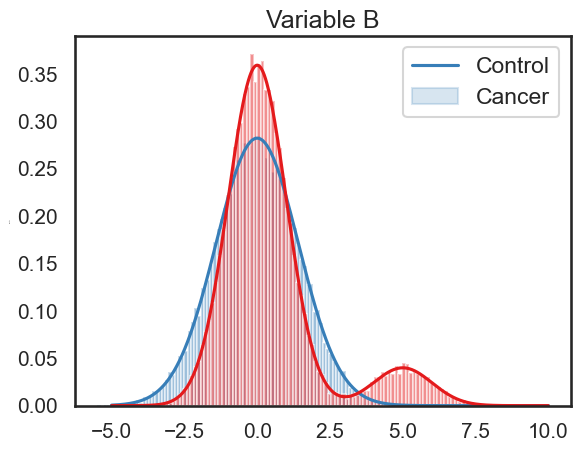

In [66]:

# Panel B & C Normal : N(0,2) vs Cancer  N(0,1)
N = 50000
prior_0, prior_1 = 0.5, 0.5
p_class0, p_class1_0, p_class1_1 = prior_0, prior_1*0.9, prior_1*0.1
p_class1 = p_class1_0 + p_class1_1
n0 = int(N*p_class0)
n1 = N-n0
n1_0 = int(n1*0.9)
n1_1 = n1-n1_0
print(n0, n1, n1_0, n1_1)
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0]* p)
mu_class1_0 = np.array([0]* p)
mu_class1_1 = np.array([5]* p)
sig_class0 = np.identity(p)*p0
sig_class1_0 = np.identity(p)*p1
sig_class1_1 = np.identity(p)*p1

density = True

# Create the probability density functions (PDFs) for the two Gaussian distributions
pdf_class0 = multivariate_normal(mu_class0, sig_class0)
pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
pdf_class1 = np.zeros_like(pdf_class0)


x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
x_2 = np.vstack((x_2_0,x_2_1))

x = np.vstack((x_1,x_2))
y = np.array([0]*n0+[1]*n1).reshape(-1,1)

p_x_given_class0 = pdf_class0.pdf(x)
p_x_given_class1_0 = pdf_class1_0.pdf(x)
p_x_given_class1_1 = pdf_class1_1.pdf(x)

p_x_given_class1 = 0.9* p_x_given_class1_0 + 0.1* p_x_given_class1_1


p_x = p_x_given_class0*p_class0 + p_x_given_class1_0*p_class1_0 + p_x_given_class1_1*p_class1_1
pos_class0 = p_x_given_class0*p_class0/p_x
# pos_class1_0 = p_x_given_class1_0*p_class1_0/p_x
# pos_class1_1 = p_x_given_class1_1*p_class1_1/p_x
pos_class1 = p_x_given_class1*p_class1/p_x

posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
# print(posterior.shape)
# posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
prior_y = np.array([p_class0,p_class1_0, p_class1_1])
entropy_y = entropy(prior_y, base=np.exp(1))
# print('entropy'+str(stats_conen))

# correlation = np.corrcoef(x_1.T, x_2.T)
MI = entropy_y - stats_conen
auc = roc_auc_score(y, posterior[:,1])
pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
tpr_s = np.max(tpr[fpr <= 0.02])
y_pred = np.argmax(posterior, axis=1)   
accuracy = metrics.accuracy_score(y, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = metrics.f1_score(y, y_pred)
report = metrics.classification_report(y, y_pred)

statistics_B = {
                    # 'Correlation': truncate(correlation[0,1], 4), 
                    'Accuracy': round(accuracy, 2), 
                    'F1': round(f1, 2), 
                    'MI': round(MI, 2), 
                    'AUC': round(auc, 2), 
                    'pAUC': round(pauc, 2), 
                    'S@98': round(tpr_s, 2), 
                    # 'Sensitivity': truncate(sensitivity), 
                    # 'Specificity': truncate(specificity), 
                    # 'TN': tn, 
                    # 'FP': fp, 
                    # 'FN': fn, 
                    # 'TP': tp
                    }
statistics_B_list = list(statistics_B.values())
# print the statistics as a dataframe
print(pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=['Variable B']))

# # plot the true pdfs
# x = np.linspace(-5, 10, 1000)
# plt.plot(x, pdf_class0.pdf(x), label='Control', color='b')
# plt.plot(x, 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x), label='Cancer', color='r')
# # plt.plot(x, pdf_class1_1.pdf(x), label='N(5,1)', color='b')
# # sample from the true pdfs to plot the histograms
# plt.hist(x_1, bins=100, density=True, alpha=0.5, color='b')
# # combine the two cancer classes
# x_2 = np.vstack((x_2_0,x_2_1))
# plt.hist(x_2, bins=100, density=True, alpha=0.5, color='r')

# plt.legend()
# plt.title('Variable B')

# plot the true pdfs using seaborn
x = np.linspace(-5, 10, 1000)
# create a df to plot the true pdfs using seaborn
df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x)})
scaler = 8
# plt.plot(df['x'], df['pdf_class0']*n0/scaler, color=PALETTE[1], linewidth=2)
# plt.plot(df['x'], df['pdf_class1']*n1/scaler, color=PALETTE[0], linewidth=2)
# plot the true pdf
sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
# sample from the true pdfs to plot the histograms
plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
# plt.hist(x_1, bins=100,  alpha=0.5, color=PALETTE[1])
# plt.hist(x_2, bins=100,  alpha=0.5, color=PALETTE[0])
# set the labels and title
plt.xlabel('')
plt.ylabel('Density',size=.5)
# set the ticks size
plt.xticks(size=15)
plt.yticks(size=15)
# set the legent size
sns.set_context("talk", font_scale=1.0)
plt.legend(['Control', 'Cancer'])
plt.title('Variable B')


In [89]:
# Define a function to calculate the statistics for Variable B
def calculate_statistics_B(n0, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, plot=False, density=True, scaler=8):

    N = n0 + n1_0 + n1_1
    n1 = N - n0
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1_0 = multivariate_normal(mu_class1_0, sig_class1_0)
    pdf_class1_1 = multivariate_normal(mu_class1_1, sig_class1_1)
    # pdf_class1 = pdf_class1_0 + pdf_class1_1

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
    x_2_0 = np.random.multivariate_normal(mu_class1_0, sig_class1_0, size=n1_0)
    x_2_1 = np.random.multivariate_normal(mu_class1_1, sig_class1_1, size=n1_1)
    x_2 = np.vstack((x_2_0,x_2_1))

    x = np.vstack((x_1,x_2_0,x_2_1))
    y = np.array([0]*n0+[1]*n1).reshape(-1,1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1_0 = pdf_class1_0.pdf(x)
    p_x_given_class1_1 = pdf_class1_1.pdf(x)

    p_x_given_class1 = 0.9* p_x_given_class1_0 + 0.1* p_x_given_class1_1

    p_x = p_x_given_class0*p_class0 + p_x_given_class1_0*p_class1_0 + p_x_given_class1_1*p_class1_1
    pos_class0 = p_x_given_class0*p_class0/p_x
    pos_class1 = p_x_given_class1*(1-p_class0)/p_x

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1_0, p_class1_1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:,1])
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)   
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)

    statistics_B = {
                        # 'Correlation': truncate(correlation[0,1], 4), 
                        'Accuracy': round(accuracy, 2), 
                        'F1': round(f1, 2), 
                        'MI': round(MI, 2), 
                        'AUC': round(auc, 2), 
                        'pAUC': round(pauc, 2), 
                        'S@98': round(tpr_s, 2), 
                        # 'Sensitivity': truncate(sensitivity), 
                        # 'Specificity': truncate(specificity), 
                        # 'TN': tn, 
                        # 'FP': fp, 
                        # 'FN': fn, 
                        # 'TP': tp
                        }
    if plot:
        # plot the true pdfs using seaborn
        fig, ax = plt.subplots(figsize=(6, 5))
        x = np.linspace(-5, 10, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x)})
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
        # plot the true pdfs
        if density:
            sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
            sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
        else:
            plt.plot(df['x'], df['pdf_class0']*n0/scaler, color=PALETTE[1], linewidth=2)
            plt.plot(df['x'], df['pdf_class1']*n1/scaler, color=PALETTE[0], linewidth=2)
            plt.legend(['Control', 'Cancer'])

        # set the labels and title
        plt.xlabel('')
        plt.ylabel('Density',size=.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.title('Variable B')
        return statistics_B, report, fig, posterior
    return statistics_B, report, posterior

25000 25000 22500 2500


/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

,Variable B
Accuracy,0.59
F1,0.63
MI,0.21
AUC,0.63
pAUC,0.55
S@98,0.11


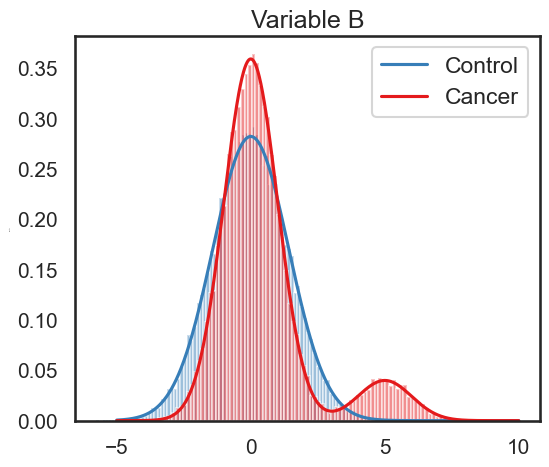

In [91]:

density = True
N = 50000
prior_0, prior_1 = 0.5, 0.5
p_class0, p_class1_0, p_class1_1 = prior_0, prior_1*0.9, prior_1*0.1
n0 = int(N*p_class0)
n1 = N-n0
n1_0 = int(n1*0.9)
n1_1 = n1-n1_0
print(n0, n1, n1_0, n1_1)
p0, p1 = 2, 1
mu_class0 = np.array([0]* p)
mu_class1_0 = np.array([0]* p)
mu_class1_1 = np.array([5]* p)
sig_class0 = np.identity(p)*p0
sig_class1_0 = np.identity(p)*p1
sig_class1_1 = np.identity(p)*p1

statistics_B, report, fig_B, posterior = calculate_statistics_B(n0, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, 
plot=True, density=density, scaler=8)
statistics_B_list = np.array(list(statistics_B.values()))
# print the statistics as a dataframe
pd.DataFrame(statistics_B_list, index=statistics_B.keys(), columns=['Variable B'])


In [92]:
# # plot x_1 and x_2 against the posterior
# plt.figure(figsize=(7, 5))
# x_1.shape, posterior[:n,0].shape
# # plt.scatter(x_1, posterior[:n,0], alpha=0.5, label='Control', color='b')
# plt.scatter(np.vstack((x_1,x_2)), posterior[:,1], alpha=0.5, label='Cancer', color=PALETTE[3], s=10)
# plt.xlabel('Variable B', size=15.0)
# plt.ylabel('Posterior Probability', size=15.0)

# def plot_posterior(x_1, x_2, posterior, title='Variable B'):
#     fig, ax = plt.subplots(figsize=(7, 5))
#     # plt.scatter(x_1, posterior[:n,0], alpha=0.5, label='Control', color='b')
#     plt.scatter(np.vstack((x_1,x_2)), posterior[:,1], alpha=0.5, label='Cancer', color=PALETTE[3], s=10)
#     plt.xlabel('Variable B', size=15.0)
#     plt.ylabel('Posterior Probability', size=15.0)
#     plt.title(title)
#     return fig
# fig_B_posterior = plot_posterior(x_1, x_2, posterior, title='Variable B')
# fig_B_posterior

          Variable A
Accuracy        0.58
F1              0.65
MI              0.03
AUC             0.61
pAUC            0.51
S@98            0.03


/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

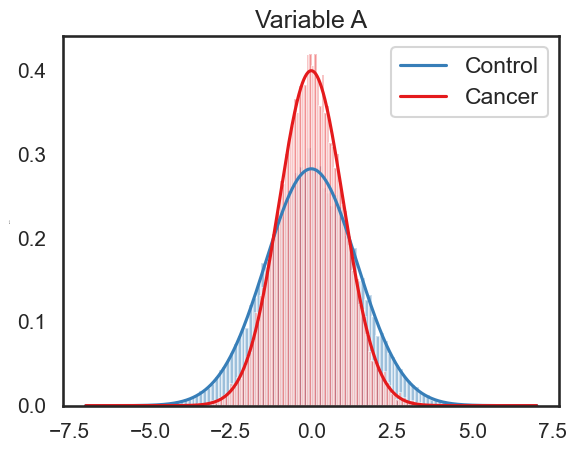

In [107]:
# Variable A Normal : N(-1,1) vs Cancer  N(1,1)


p = 1 # number of features
p0, p1 = 2, 1 # variances of the two classes
mu_class0 = np.array([0]* p)
mu_class1 = np.array([0]* p)
sig_class0 = np.identity(p)*p0
sig_class1 = np.identity(p)*p1

N = 50000
p_class0, p_class1 = 0.5, 0.5
n0 = int(N*p_class0)
n1 = N - n0
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0]* p)
mu_class1 = np.array([0]* p)
sig_class0 = np.identity(p)*p0
sig_class1 = np.identity(p)*p1


density = True
scaler = 12

# Create the probability density functions (PDFs) for the two Gaussian distributions
pdf_class0 = multivariate_normal(mu_class0, sig_class0)
pdf_class1 = multivariate_normal(mu_class1, sig_class1)


x_0 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
x_1 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

x = np.vstack((x_0,x_1))
y = np.array([0]*n0+[1]*n1).reshape(-1,1)

p_x_given_class0 = pdf_class0.pdf(x)
p_x_given_class1 = pdf_class1.pdf(x)


p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
pos_class0 = p_x_given_class0*p_class0/p_x
pos_class1 = p_x_given_class1*p_class1/p_x


posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
# print(posterior.shape)
# display(posterior[:5])
# posterior = posterior[~np.isnan(posterior)].reshape(-1,2)
stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
prior_y = np.array([p_class0,p_class1])
entropy_y = entropy(prior_y, base=np.exp(1))

# correlation = np.corrcoef(x_1.T, x_2.T)
MI = entropy_y - stats_conen
auc = roc_auc_score(y, posterior[:,1])
pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
tpr_s = np.max(tpr[fpr <= 0.02])
y_pred = np.argmax(posterior, axis=1)   
accuracy = metrics.accuracy_score(y, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = metrics.f1_score(y, y_pred)
report = metrics.classification_report(y, y_pred)

statistics_A = {
                # 'Correlation': truncate(correlation[0,1], 4), 
                'Accuracy': truncate(accuracy), 
                'F1': truncate(f1), 
                'MI': truncate(MI), 
                'AUC': truncate(auc), 
                'pAUC': truncate(pauc), 
                'S@98': truncate(tpr_s), 
                # 'Sensitivity': truncate(sensitivity), 
                # 'Specificity': truncate(specificity), 
                # 'TN': tn, 
                # 'FP': fp, 
                # 'FN': fn, 
                # 'TP': tp
                }

statistics_A_list = list(statistics_A.values())
# print the statistics as a dataframe
print(pd.DataFrame(statistics_A_list, index=statistics_A.keys(), columns=['Variable A']))
# plot the true pdfs using seaborn
x = np.linspace(-7, 7, 1000)
# create a df to plot the true pdfs using seaborn
df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': pdf_class1.pdf(x)})
# plot the true pdfs
if density:
    sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
    sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])

else:
    plt.plot(df['x'], df['pdf_class0']*n0*np.sqrt(p0)/scaler, color=PALETTE[1], linewidth=2)
    plt.plot(df['x'], df['pdf_class1']*n1*np.sqrt(p1)/scaler, color=PALETTE[0], linewidth=2)
    plt.legend(['Control', 'Cancer'])
# sample from the true pdfs to plot the histograms
plt.hist(x_0, bins=100, density=density, alpha=0.5, color=PALETTE[1])
plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[0])

# set the labels and title
plt.xlabel('')
plt.ylabel('Density',size=1.0)
plt.xticks(size=15)
plt.yticks(size=15)

plt.title('Variable A')
# set the legent size
sns.set_context("talk", font_scale=1.0)

# # plot x_1 and x_2 against the posterior
# plt.figure(figsize=(6, 5))
# x_1.shape, posterior[:n,0].shape
# # plt.scatter(x_1, posterior[:n,0], alpha=0.5, label='Control', color='b')
# plt.scatter(np.vstack((x_1,x_2)), posterior[:,1], alpha=0.5, label='Cancer', color=PALETTE[3], s=10)
# plt.xlabel('Variable A', size=15.0)
# plt.ylabel('Posterior Probability', size=15.0)

In [ ]:
    if plot:
        # plot the true pdfs using seaborn
        fig, ax = plt.subplots(figsize=(6, 5))
        x = np.linspace(-5, 10, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': 0.9*pdf_class1_0.pdf(x) + 0.1*pdf_class1_1.pdf(x)})
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
        # plot the true pdfs
        if density:
            sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
            sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
        else:
            plt.plot(df['x'], df['pdf_class0']*n0/scaler, color=PALETTE[1], linewidth=2)
            plt.plot(df['x'], df['pdf_class1']*n1/scaler, color=PALETTE[0], linewidth=2)
            plt.legend(['Control', 'Cancer'])

        # set the labels and title
        plt.xlabel('')
        plt.ylabel('Density',size=.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.title('Variable B')
        return statistics_B, report, fig, posterior

In [113]:
# define a function to generate the statistics
def generate_statistics_A(N, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1, plot=False, density=True,scaler=8):
    n0 = int(N*p_class0)
    n1 = N - n0
    # Create the probability density functions (PDFs) for the two Gaussian distributions
    pdf_class0 = multivariate_normal(mu_class0, sig_class0)
    pdf_class1 = multivariate_normal(mu_class1, sig_class1)

    x_1 = np.random.multivariate_normal(mu_class0, sig_class0, size=n0)
    x_2 = np.random.multivariate_normal(mu_class1, sig_class1, size=n1)

    x = np.vstack((x_1,x_2))
    y = np.array([0]*n0+[1]*n1).reshape(-1,1)

    p_x_given_class0 = pdf_class0.pdf(x)
    p_x_given_class1 = pdf_class1.pdf(x)

    p_x = p_x_given_class0*p_class0 + p_x_given_class1*p_class1
    pos_class0 = p_x_given_class0*p_class0/p_x
    pos_class1 = p_x_given_class1*p_class1/p_x

    posterior = np.hstack((pos_class0.reshape(-1,1),pos_class1.reshape(-1,1)))
    stats_conen = np.mean(entropy(posterior, base=np.exp(1), axis=1))
    prior_y = np.array([p_class0,p_class1])
    entropy_y = entropy(prior_y, base=np.exp(1))
    # correlation = np.corrcoef(x_1.T, x_2.T)
    MI = entropy_y - stats_conen
    auc = roc_auc_score(y, posterior[:,1])
    pauc = roc_auc_score(y, posterior[:,1], max_fpr=0.1)
    fpr, tpr, thresholds = metrics.roc_curve(y, posterior[:,1], pos_label=1,drop_intermediate = False)
    tpr_s = np.max(tpr[fpr <= 0.02])
    y_pred = np.argmax(posterior, axis=1)   
    accuracy = metrics.accuracy_score(y, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = metrics.f1_score(y, y_pred)
    report = metrics.classification_report(y, y_pred)
    # return MI, auc, pauc, tpr_s, sensitivity, specificity, accuracy, f1, report,  tn, fp, fn, tp
    # create a dictionary to store the statistics in order of correlation, accuracy, AUC, pAUC, F1,  MI, S@98, Sensitivity, Specificity, F1, TN, FP, FN, TP, report
    statistics_A = {
                    # 'Correlation': truncate(correlation[0,1], 4), 
                    'Accuracy': truncate(accuracy), 
                    'F1': truncate(f1), 
                    'MI': truncate(MI), 
                    'AUC': truncate(auc), 
                    'pAUC': truncate(pauc), 
                    'S@98': truncate(tpr_s), 
                    # 'Sensitivity': truncate(sensitivity), 
                    # 'Specificity': truncate(specificity), 
                    # 'TN': tn, 
                    # 'FP': fp, 
                    # 'FN': fn, 
                    # 'TP': tp
                    }
    if plot:
        # plot the true pdfs using seaborn
        fig, ax = plt.subplots(figsize=(6, 5))
        x = np.linspace(-5, 10, 1000)
        # create a df to plot the true pdfs using seaborn
        df = pd.DataFrame({'x': x, 'pdf_class0': pdf_class0.pdf(x), 'pdf_class1': pdf_class1.pdf(x)})
        # sample from the true pdfs to plot the histograms
        plt.hist(x_1, bins=100, density=density, alpha=0.5, color=PALETTE[1])
        plt.hist(x_2, bins=100, density=density, alpha=0.5, color=PALETTE[0])
        # plot the true pdfs
        if density:
            sns.lineplot(df, x='x', y='pdf_class0', label='Control', color=PALETTE[1])
            sns.lineplot(df, x='x', y='pdf_class1', label='Cancer', color=PALETTE[0])
        else:
            plt.plot(df['x'], df['pdf_class0']*n0/scaler, color=PALETTE[1], linewidth=2)
            plt.plot(df['x'], df['pdf_class1']*n1/scaler, color=PALETTE[0], linewidth=2)
            plt.legend(['Control', 'Cancer'])

        # set the labels and title
        plt.xlabel('')
        plt.ylabel('Density',size=.5)
        # set the ticks size
        plt.xticks(size=15)
        plt.yticks(size=15)
        # set the legent size
        sns.set_context("talk", font_scale=1.0)
        plt.title('Variable B')
        return statistics_B, report, fig, posterior
    return statistics_A, report, posterior

25000 25000 22500 2500
\begin{tabular}{llll}
\toprule
 & Variable A & Relations & Variable B \\
\midrule
Accuracy & 0.59 & = & 0.59 \\
F1 & 0.63 & = & 0.63 \\
MI & 0.21 & = & 0.21 \\
AUC & 0.64 & = & 0.64 \\
pAUC & 0.55 & = & 0.55 \\
S@98 & 0.11 & = & 0.11 \\
\bottomrule
\end{tabular}



/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suki/miniconda3/envs/sktree/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

,Variable A,Relations,Variable B
Accuracy,0.59,=,0.59
F1,0.63,=,0.63
MI,0.21,=,0.21
AUC,0.64,=,0.64
pAUC,0.55,=,0.55
S@98,0.11,=,0.11


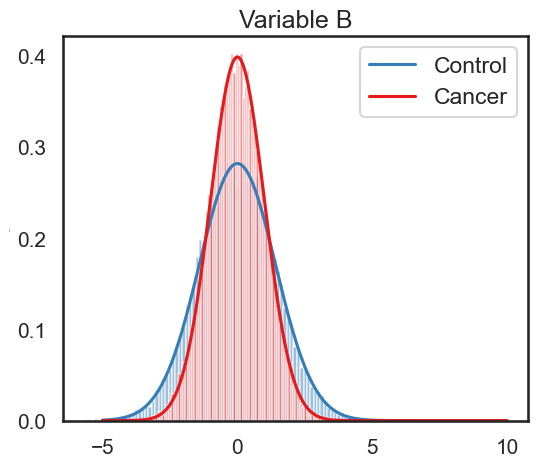

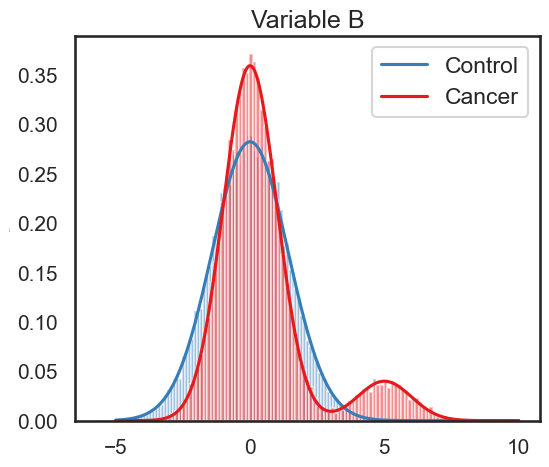

In [114]:
density = True
N = 50000
p = 1
p0, p1 = 2, 1
mu_class0 = np.array([0]* p)
mu_class1 = np.array([0]* p)
sig_class0 = np.identity(p)*p0
sig_class1 = np.identity(p)*p1
p_class0, p_class1 = 0.5, 0.5
statistics_A, report, fig, posterior= generate_statistics_A(N, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1,
plot=True, density=density, scaler=11.5)
statistics_A_list = np.array(list(statistics_A.values()))


p_class0, p_class1_0, p_class1_1 = p_class0, p_class1*0.9, p_class1*0.1
n0 = int(N*p_class0)
n1 = N-n0
n1_0 = int(n1*0.9)
n1_1 = n1-n1_0
print(n0, n1, n1_0, n1_1)
p = 1
mu_class0 = np.array([0]* p)
mu_class1_0 = np.array([0]* p)
mu_class1_1 = np.array([5]* p)
sig_class0 = np.identity(p)*2
sig_class1_0 = np.identity(p)*1
sig_class1_1 = np.identity(p)*1

statistics_B, report, fig_B, posterior = calculate_statistics_B(n0, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, 
plot=True, density=density, scaler=8)
statistics_B_list = np.array(list(statistics_B.values()))

# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
relations = np.array([compare(statistics_A_list[i], statistics_B_list[i]) for i in range(len(statistics_A_list))])
# print the statistics as a dataframe
df = pd.DataFrame(np.vstack((statistics_A_list, relations, statistics_B_list)).T, index=statistics_A.keys(), columns=['Variable A', 'Relations', 'Variable B'])
print(df.to_latex())
df

45000 5000 4500 500
\begin{tabular}{llll}
\toprule
 & Variable A & Relations & Variable B \\
\midrule
Accuracy & 0.91 & > & 0.9 \\
F1 & 0.27 & > & 0.13 \\
MI & 0.04 & < & 0.05 \\
AUC & 0.7 & > & 0.63 \\
pAUC & 0.63 & > & 0.55 \\
S@98 & 0.24 & > & 0.1 \\
\bottomrule
\end{tabular}



,Variable A,Relations,Variable B
Accuracy,0.91,>,0.9
F1,0.27,>,0.13
MI,0.04,<,0.05
AUC,0.7,>,0.63
pAUC,0.63,>,0.55
S@98,0.24,>,0.1


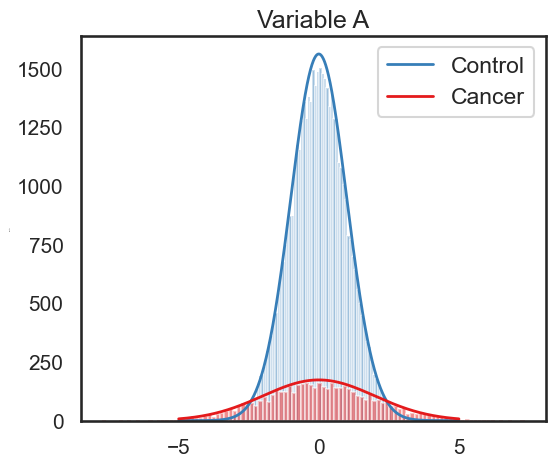

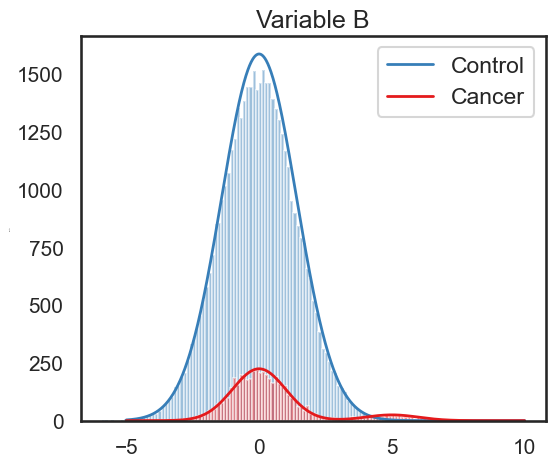

In [14]:
N = 50000
p = 1
p0, p1 = 1, 4
mu_class0 = np.array([0]* p)
mu_class1 = np.array([0]* p)
sig_class0 = np.identity(p)*p0
sig_class1 = np.identity(p)*p1
p_class0, p_class1 = 0.9, 0.1
statistics_A, report, fig, posterior= generate_statistics_A(N, p, mu_class0, mu_class1, sig_class0, sig_class1, p_class0, p_class1,
 plot=True, density=False, scaler=11.5)
statistics_A_list = np.array(list(statistics_A.values()))

N = 50000
p_class0, p_class1_0, p_class1_1 = 0.9, 0.1*0.9, 0.1*0.1
n0 = int(N*p_class0)
n1 = N-n0
n1_0 = int(n1*0.9)
n1_1 = n1-n1_0
print(n0, n1, n1_0, n1_1)
p = 1
mu_class0 = np.array([0]* p)
mu_class1_0 = np.array([0]* p)
mu_class1_1 = np.array([5]* p)
sig_class0 = np.identity(p)*2
sig_class1_0 = np.identity(p)*1
sig_class1_1 = np.identity(p)*1

statistics_B, report, fig_B, posterior = calculate_statistics_B(n0, n1_0, n1_1, p, mu_class0, mu_class1_0, mu_class1_1, sig_class0, sig_class1_0, sig_class1_1, p_class0, p_class1_0, p_class1_1, 
plot=True, density=False, scaler=8)
statistics_B_list = np.array(list(statistics_B.values()))

# generate function to return '>' if the value A is greater than B, '<' if the value A is less than B, and '=' if the values are equal
relations = np.array([compare(statistics_A_list[i], statistics_B_list[i]) for i in range(len(statistics_A_list))])
# print the statistics as a dataframe
df = pd.DataFrame(np.vstack((statistics_A_list, relations, statistics_B_list)).T, index=statistics_A.keys(), columns=['Variable A', 'Relations', 'Variable B'])
print(df.to_latex())
df